In [1]:
from os import path, listdir
import math
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common import results_plotter
from stable_baselines3.common.results_plotter import load_results, ts2xy #, plot_results
from scipy.stats import skewnorm

%matplotlib notebook

<IPython.core.display.Javascript object>


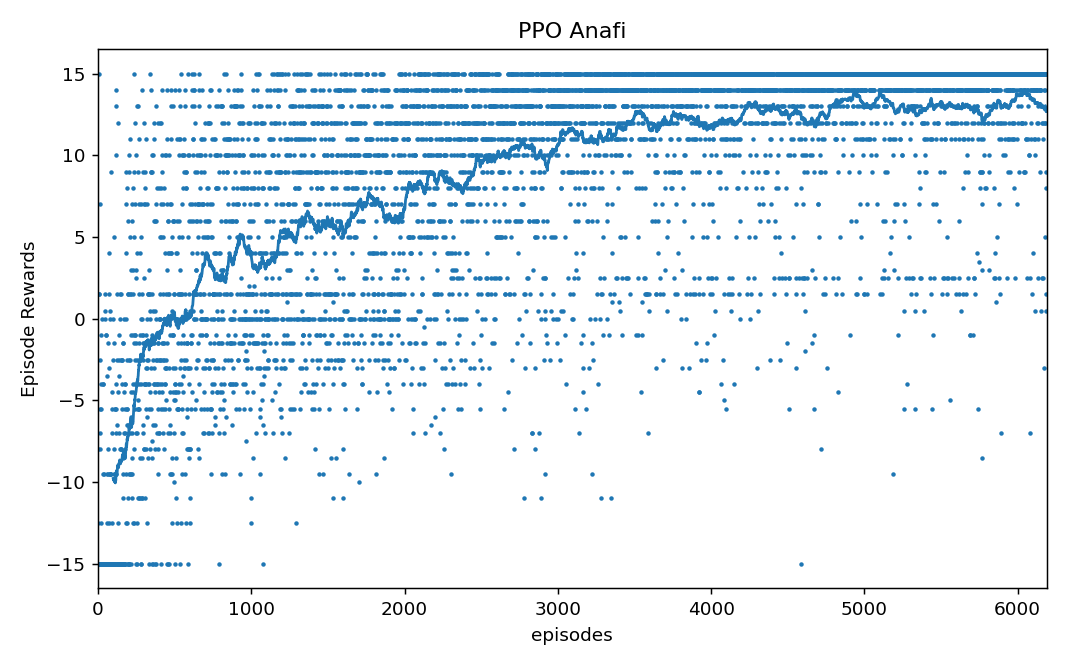

In [2]:
results_plotter.plot_results(["./logs"], 60_000, results_plotter.X_EPISODES, "PPO Anafi", (8, 5))

In [3]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'episodes')
    y = moving_average(y, window=100)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Episode')
    plt.ylabel('Return')
#     plt.title(title + " Smoothed")
    plt.title("Return vs. Episode")
    plt.grid(which="both", axis="y")
    plt.grid(which="major", axis="x")
    plt.minorticks_on()
    plt.rc('font', size=20)
    plt.tight_layout()
#     plt.savefig("episode_returns.pdf")
    plt.show()

<IPython.core.display.Javascript object>


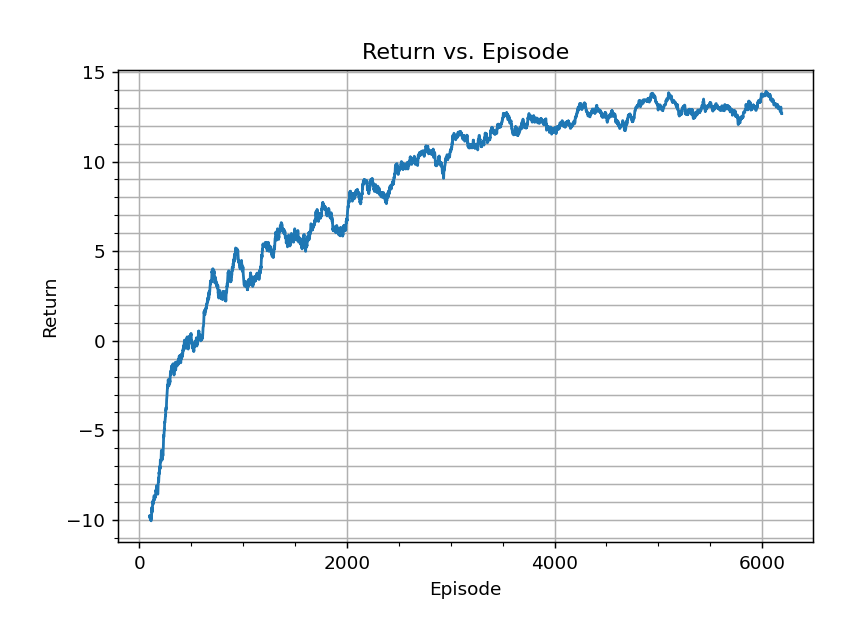

In [4]:
plot_results("./logs")

<IPython.core.display.Javascript object>


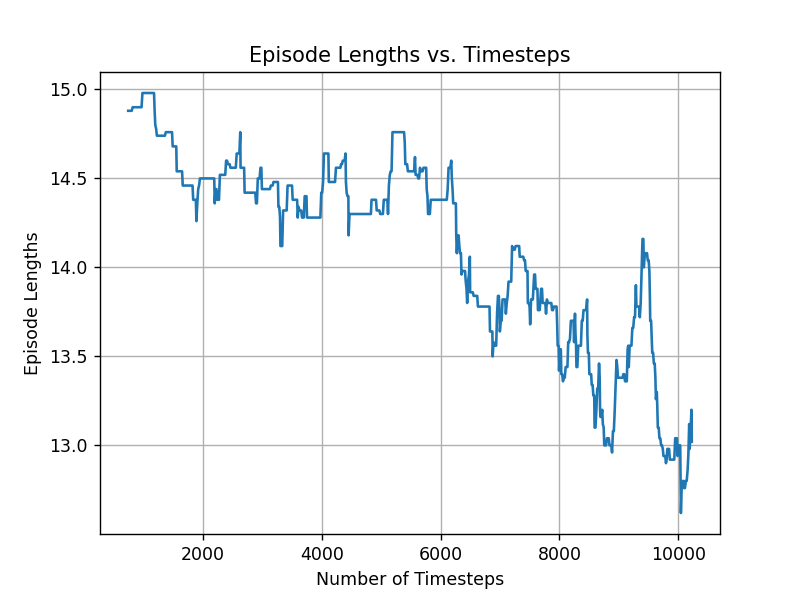

In [38]:
fig = plt.figure()
plt.plot(x, length_mean)
plt.xlabel('Number of Timesteps')
plt.ylabel('Episode Lengths')
plt.title("Episode Lengths vs. Timesteps")
plt.grid()
plt.savefig("episode_lengths.pdf")
plt.show()

In [5]:
distance_per_action = {
  **dict.fromkeys(['FL', 'FR', 'BL', 'BR'], math.sqrt(89)), 
  **dict.fromkeys(['F', 'B'], 5),
  **dict.fromkeys(['L', 'R'], 8),
  **dict.fromkeys(['H'], 0),
}
# TIME CALCULATION PARAMETERS
speed = 5 # m/s
processing_time = 1 # s
hovering_time = 2 # s

# ENERGY CALCULATION PARAMETERS
power_per_movement = 20 # W
power_per_hovering = 10 # W

In [6]:
def calc_time_energy(filename):
#     print(filename)
    data = np.genfromtxt(filename, delimiter=",", skip_header=1, dtype=None, encoding="ascii")

    tot_time, tot_energy = 0, 0
    for line in data:
        action = line[1]
        distance = distance_per_action[action]
        if action == "H":
            tot_time += hovering_time + processing_time
            tot_energy += (hovering_time + processing_time) * power_per_hovering
        else:
            tot_time += distance / speed + processing_time
            tot_energy += (distance / speed) * power_per_movement + processing_time * power_per_hovering

    return tot_time, tot_energy

In [7]:
time_to_cell_25 = ( 
    ( math.sqrt(356) / speed + processing_time )    # cell 13 -> cell 1
    + 5*( 4*( 8/speed + processing_time ) )         # horizontal movements
    + 4*( math.sqrt(1049)/speed + processing_time ) # long diagonal
)

time_to_cell_24 = time_to_cell_25 - (8/speed + processing_time)

energy_to_cell_25 = ( 
    ( (math.sqrt(356)/speed)*power_per_movement + processing_time*power_per_hovering ) 
    + 5*( 4*( (8/speed)*power_per_movement + processing_time*power_per_hovering ) ) 
    + 4*( (math.sqrt(1049)/speed)*power_per_movement + processing_time*power_per_hovering )
)

energy_to_cell_24 = energy_to_cell_25 - ((8/speed)*power_per_movement + processing_time*power_per_hovering)

In [8]:
reverse_time_to_cell_20 = ( 
    ( math.sqrt(356) / speed + processing_time ) 
    + 1*( 4*( 8/speed + processing_time ) ) 
    + 1*( math.sqrt(1049)/speed + processing_time )
)

reverse_time_to_cell_19 = reverse_time_to_cell_20 + (8/speed + processing_time)

reverse_time_to_cell_14 = ( 
    reverse_time_to_cell_19 
    + 4*( 4*( 8/speed + processing_time ) ) 
    + 1*( math.sqrt(1049)/speed + processing_time ) 
)

reverse_energy_to_cell_20 = (
    ( (math.sqrt(356)/speed)*power_per_movement + processing_time*power_per_hovering ) 
    + 1*( 4*( (8/speed)*power_per_movement + processing_time*power_per_hovering ) ) 
    + 1*( (math.sqrt(1049)/speed)*power_per_movement + processing_time*power_per_hovering ) 
)

reverse_energy_to_cell_19 = reverse_energy_to_cell_20 + ((8/speed)*power_per_movement + processing_time*power_per_hovering)
reverse_energy_to_cell_14 = (
    reverse_energy_to_cell_19 
    + 4*((8/speed)*power_per_movement + processing_time*power_per_hovering) 
    + 1*((math.sqrt(1049)/speed)*power_per_movement + processing_time*power_per_hovering)
)

In [14]:
types = ["rl", "zigzag1", "zigzag2", "random"]
base_dir = "boxplot"
data = {}
for t in types:
#     data[t] = np.zeros( ( 2, len(files) ) )
    data[t] = np.zeros( ( 2, 10 ) )
    type_dir = path.join(base_dir, t)
    if not path.isdir(type_dir):
        continue
    files = listdir(type_dir)
    for count, filename in enumerate(files):
        file = path.join(type_dir, filename)
        if path.isfile(file): # and is_csv(file):
            data[t][0, count], data[t][1, count] = calc_time_energy(file)

In [15]:
data["zigzag1"][0] = np.array(4*[time_to_cell_24] + 6*[time_to_cell_25])
data["zigzag1"][1] = np.array(4*[energy_to_cell_24] + 6*[energy_to_cell_25])

In [16]:
data["zigzag2"][0] = np.array([reverse_time_to_cell_14] + [reverse_time_to_cell_19] + 8*[reverse_time_to_cell_20])
data["zigzag2"][1] = np.array([reverse_energy_to_cell_14] + [reverse_energy_to_cell_19] + 8*[reverse_energy_to_cell_20])

In [17]:
data["zigzag2"]

array([[ 74.32890025,  25.25124635,  22.65124635,  22.65124635,
         22.65124635,  22.65124635,  22.65124635,  22.65124635,
         22.65124635,  22.65124635],
       [742.57800491, 435.02492698, 393.02492698, 393.02492698,
        393.02492698, 393.02492698, 393.02492698, 393.02492698,
        393.02492698, 393.02492698]])

In [15]:
data["zigzag1"]

array([[  84.08420804,   84.08420804,   84.08420804,   84.08420804,
          86.68420804,   86.68420804,   86.68420804,   86.68420804,
          86.68420804,   86.68420804],
       [1441.68416076, 1441.68416076, 1441.68416076, 1441.68416076,
        1483.68416076, 1483.68416076, 1483.68416076, 1483.68416076,
        1483.68416076, 1483.68416076]])

In [55]:
def is_csv(infile):
    try:
        with open(infile, newline='') as csvfile:
            start = csvfile.read(4096)

            # isprintable does not allow newlines, printable does not allow umlauts...
            if not all([c in string.printable or c.isprintable() for c in start]):
                return False
            dialect = csv.Sniffer().sniff(start)
            return True
    except Exception:
        # Could not get a csv dialect -> probably not a csv.
        return False

In [20]:
# TIME CALCULATION PARAMETERS
speed = 5 # m/s
processing_time = 1 # s
hovering_time = 0 # s

# ENERGY CALCULATION PARAMETERS
power_per_movement = 20 # W
power_per_hovering = 10 # W

times, energies = [], []
for i in range(1, 11):
    filename = "random_episode_" + str(i) + ".csv"
    print(filename)
    data = np.genfromtxt(filename, delimiter=",", skip_header=1, dtype=None, encoding="ascii")
    
    tot_time, tot_energy = 0, 0
    for line in data:
        action = line[1]
        distance = distance_per_action[action]
        tot_time += distance / speed + hovering_time + processing_time
        tot_energy += distance / speed * power_per_movement + (hovering_time + processing_time) * power_per_hovering
 
    times.append(tot_time)
    energies.append(tot_energy)

random_episode_1.csv
random_episode_2.csv
random_episode_3.csv
random_episode_4.csv
random_episode_5.csv
random_episode_6.csv
random_episode_7.csv
random_episode_8.csv
random_episode_9.csv
random_episode_10.csv


<IPython.core.display.Javascript object>


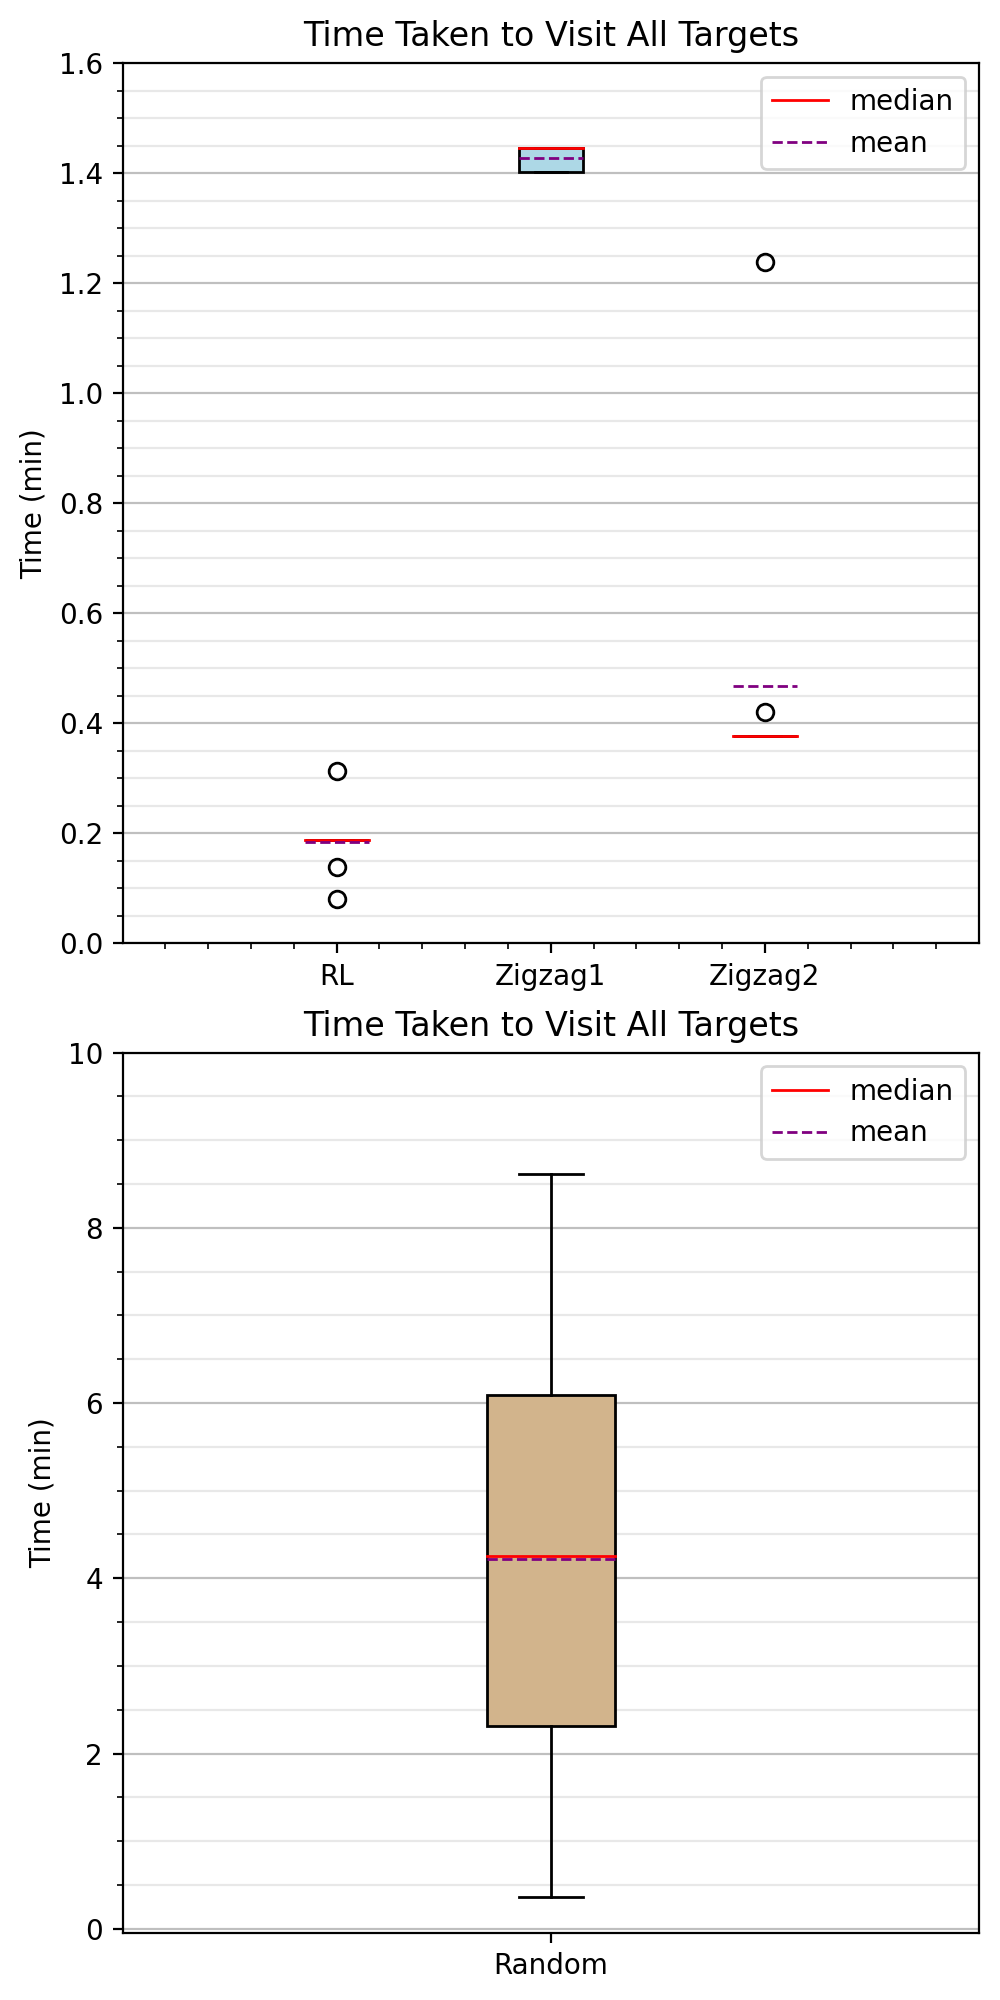

In [22]:
fig, axes = plt.subplots(2, figsize=(5, 10), dpi=150)

ax = axes[0]
ax2 = axes[1]
bp = ax.boxplot([data[t][0]/60 for t in types[:-1]], 
                positions=[1,2,3],
#                 notch=True,
                showmeans=True, 
                meanline=True, 
                patch_artist=True,
#                 showfliers=False,
                medianprops=dict(color="red"),
                meanprops=dict(color="purple"),
#                 boxprops=dict(facecolor="C0"),
               )

bp2 = ax2.boxplot(data["random"][0]/60, 
                positions=[1],
#                 notch=True,
                showmeans=True, 
                meanline=True, 
                patch_artist=True,
                showfliers=False,
                medianprops=dict(color="red"),
                meanprops=dict(color="purple"),
                boxprops=dict(facecolor="tan"),
               )

colors = ['pink', 'lightblue', 'lightgreen'] #, 'tan'] # ["C0", "C2", "C3"]
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)

ax.legend(
#     bp["boxes"] + 
    [bp['medians'][0], bp['means'][0]], 
#           [t.upper() if t == "rl" else t.capitalize() for t in types] + 
          ['median', 'mean'], 
          loc='upper right')

ax2.legend(
    [bp['medians'][0], bp['means'][0]], 
    ['median', 'mean'], 
    loc='upper right',
)

ax.set_xticks([1, 2, 3], ["RL", "Zigzag1", "Zigzag2"])
ax2.set_xticks([1], ["Random"])

ax.set_yticks(np.linspace(0, 1.6, 9))
ax2.set_yticks(np.linspace(0, 10, 6))

ax.set_xlim(0, 4)

ax.set_ylabel("Time (min)")
ax2.set_ylabel("Time (min)")

ax.set_title("Time Taken to Visit All Targets")
ax2.set_title("Time Taken to Visit All Targets")

ax.yaxis.grid(True, linestyle='-', which='major', color='grey',
               alpha=0.5)
ax.yaxis.grid(True, linestyle='-', which='minor', color='lightgrey',
               alpha=0.5)
ax.minorticks_on()

ax2.yaxis.grid(True, linestyle='-', which='major', color='grey',
               alpha=0.5)
ax2.yaxis.grid(True, linestyle='-', which='minor', color='lightgrey',
               alpha=0.5)
ax2.minorticks_on()

plt.rc('font', size=7)
plt.tight_layout()
# plt.savefig("time_taken.pdf")

In [27]:
data["zigzag2"][0]/60

array([1.238815  , 0.42085411, 0.37752077, 0.37752077, 0.37752077,
       0.37752077, 0.37752077, 0.37752077, 0.37752077, 0.37752077])

<IPython.core.display.Javascript object>


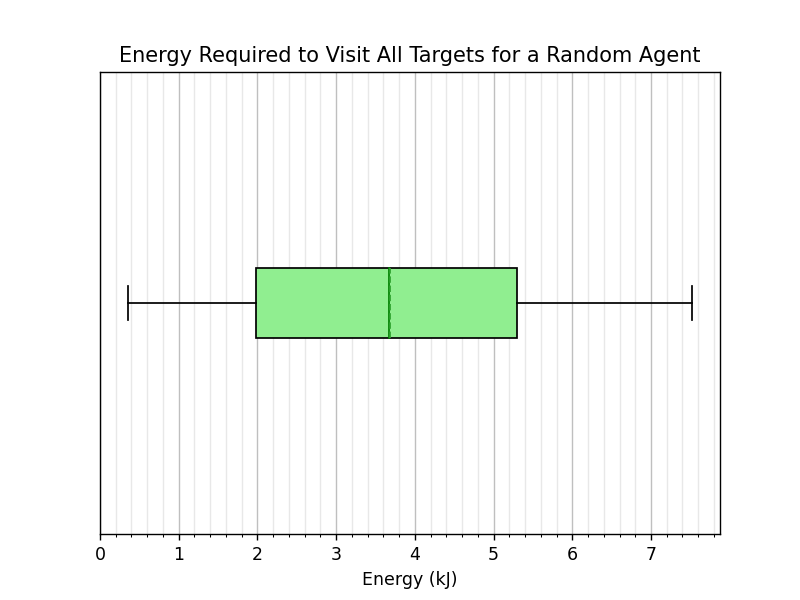

In [9]:
fig, ax = plt.subplots()
bplot = ax.boxplot(np.array(energies)/1e3, showmeans=True, meanline=True, vert=False, patch_artist=True)
bplot["boxes"][0].set_facecolor("lightgreen")
bplot["medians"][0].set_color("green")
ax.set_yticks([])
ax.set_xticks(np.linspace(0, 7, 8))
ax.set_xlabel("Energy (kJ)")
ax.set_title("Energy Required to Visit All Targets for a Random Agent")
ax.xaxis.grid(True, linestyle='-', which='major', color='grey',
               alpha=0.5)
ax.xaxis.grid(True, linestyle='-', which='minor', color='lightgrey',
               alpha=0.5)
ax.minorticks_on()
# plt.savefig("energy_required.pdf")

In [100]:
np.linspace(0, 120, 7)

array([  0.,  20.,  40.,  60.,  80., 100., 120.])

<IPython.core.display.Javascript object>


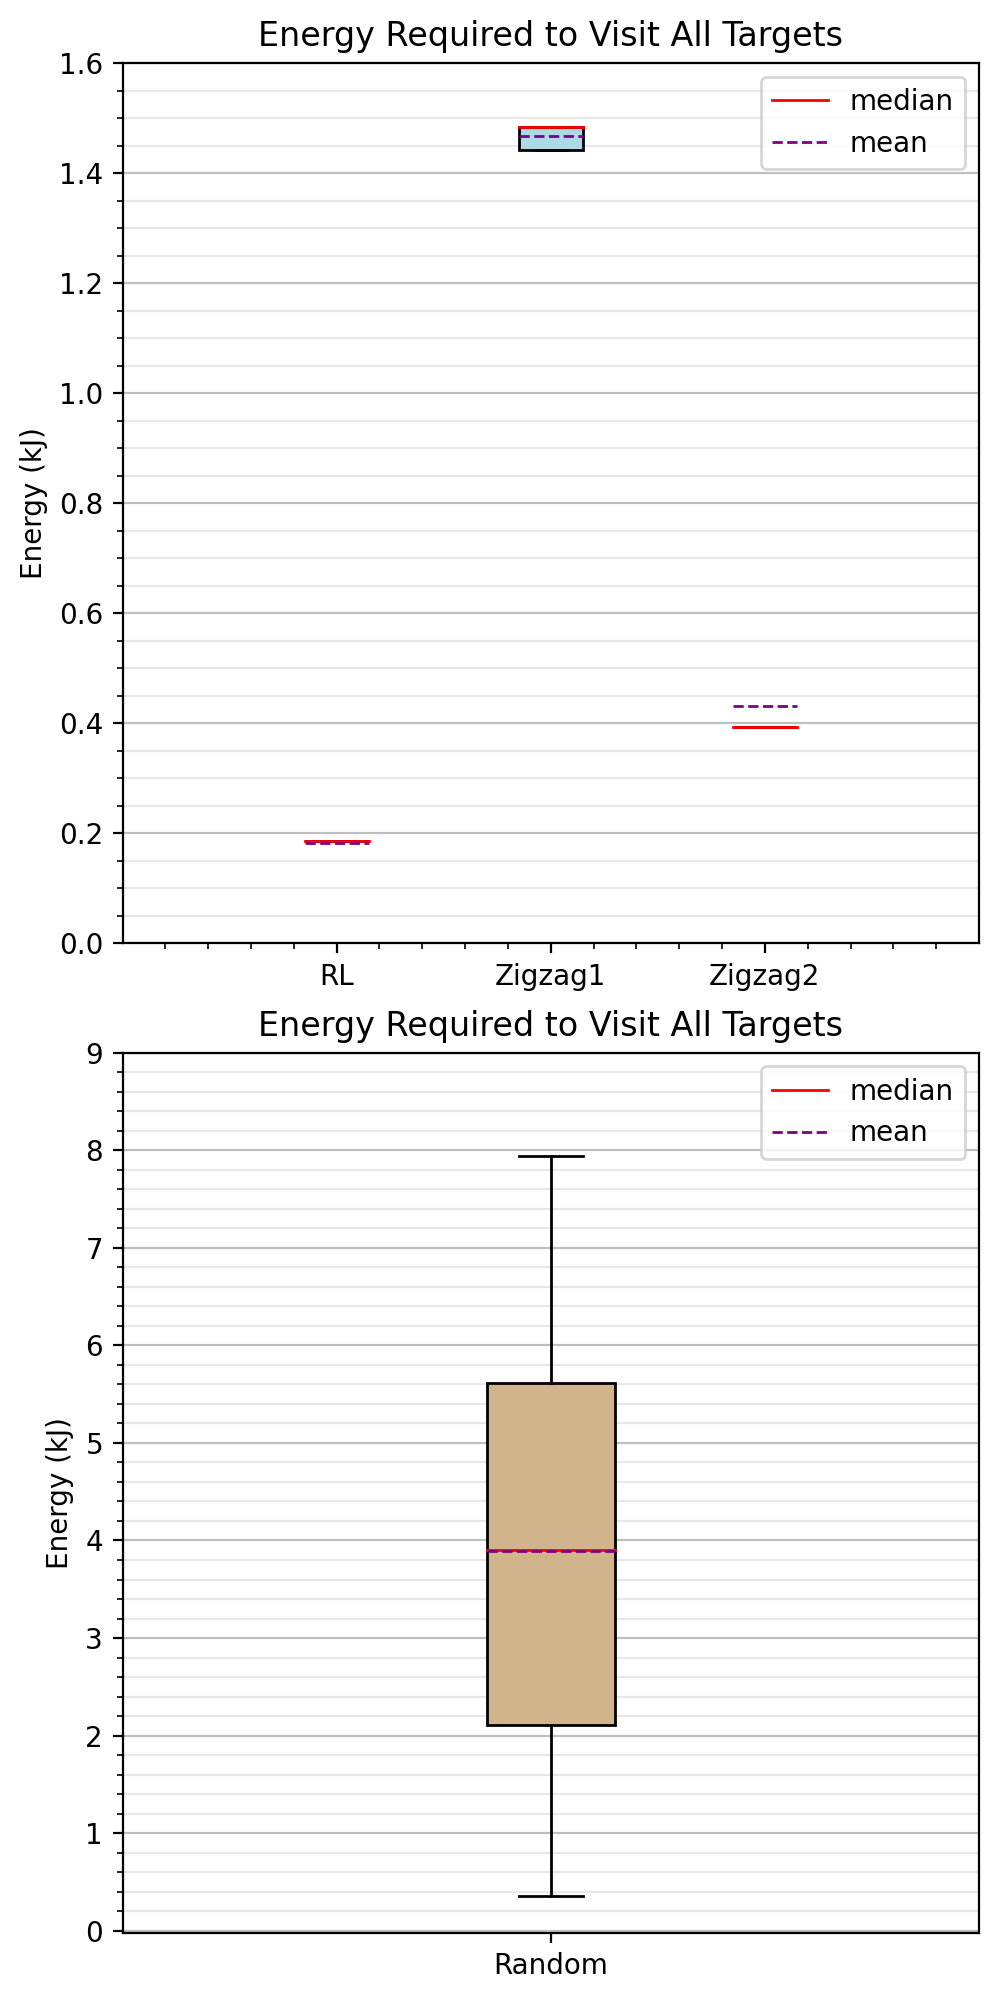

In [24]:
fig, axes = plt.subplots(2, figsize=(5, 10), dpi=150)

ax = axes[0]
ax2 = axes[1]
bp = ax.boxplot([data[t][1]/1e3 for t in types[:-1]], 
                positions=[1,2,3],
#                 notch=True,
                showmeans=True, 
                meanline=True, 
                patch_artist=True,
                showfliers=False,
                medianprops=dict(color="red"),
                meanprops=dict(color="purple"),
#                 boxprops=dict(facecolor="C0"),
               )

bp2 = ax2.boxplot(data["random"][1]/1e3, 
                positions=[1],
#                 notch=True,
                showmeans=True, 
                meanline=True, 
                patch_artist=True,
                showfliers=False,
                medianprops=dict(color="red"),
                meanprops=dict(color="purple"),
                boxprops=dict(facecolor="tan"),
               )

colors = ['pink', 'lightblue', 'lightgreen'] #, 'tan'] # ["C0", "C2", "C3"]
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)

ax.legend(
#     bp["boxes"] + 
    [bp['medians'][0], bp['means'][0]], 
#           [t.upper() if t == "rl" else t.capitalize() for t in types] + 
          ['median', 'mean'], 
          loc='upper right')

ax2.legend(
    [bp['medians'][0], bp['means'][0]], 
    ['median', 'mean'], 
    loc='upper right',
)

ax.set_xticks([1, 2, 3], ["RL", "Zigzag1", "Zigzag2"])
ax2.set_xticks([1], ["Random"])

ax.set_yticks(np.linspace(0, 1.6, 9))
ax2.set_yticks(np.linspace(0, 9, 10))

ax.set_xlim(0, 4)

ax.set_ylabel("Energy (kJ)")
ax2.set_ylabel("Energy (kJ)")

ax.set_title("Energy Required to Visit All Targets")
ax2.set_title("Energy Required to Visit All Targets")

ax.yaxis.grid(True, linestyle='-', which='major', color='grey',
               alpha=0.5)
ax.yaxis.grid(True, linestyle='-', which='minor', color='lightgrey',
               alpha=0.5)
ax.minorticks_on()

ax2.yaxis.grid(True, linestyle='-', which='major', color='grey',
               alpha=0.5)
ax2.yaxis.grid(True, linestyle='-', which='minor', color='lightgrey',
               alpha=0.5)
ax2.minorticks_on()

plt.rc('font', size=7)
plt.tight_layout()
# plt.savefig("energy_required.pdf")